In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import pandas_gbq

# Import

In [10]:
project_id = "rental-price-prediction"
query_landed = """
SELECT * FROM ura_data.landed_data;
"""
query_nonlanded = """
SELECT * FROM ura_data.nonlanded_data;
"""
landed = pandas_gbq.read_gbq(query_landed, project_id=project_id, dialect="standard") # Terrace House, Detached House, Semi-Detached House
nonlanded = pandas_gbq.read_gbq(query_nonlanded, project_id=project_id, dialect="standard") # Non-landed Properties, Executive Condominium

Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [13]:
print(landed.shape)
landed[landed["x"] == 0]["y"].value_counts()

(20158, 14)


Series([], Name: count, dtype: int64)

In [14]:
print(nonlanded.shape)
nonlanded[nonlanded["x"] == 0]["y"].value_counts()

(237170, 16)


Series([], Name: count, dtype: int64)

# One Hot Encoding

In [15]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)

# Functions

## VIF

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def get_VIF(features, df):
    # the independent variables set
    X = df[features]
    
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
    print(vif_data)#### Correlation Plot

## Correlation Plot

In [17]:
import seaborn as sns
def get_corr_plot(df):
    """all features must be numerical"""
    corr = df.corr()
    sns.set (rc = {'figure.figsize':(8,8)})
    sns.heatmap(corr, cmap='RdBu',annot=True, vmin=-1, vmax=1)


## Pairs Plot

In [18]:
def pairs(df):
    """all features must be numerical"""
    axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (10,10))
    plt.tight_layout()

## LRM

In [19]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_lrm(X_train_df: pd.DataFrame, y_train: pd.Series, X_test_df: pd.DataFrame, y_test: pd.Series, features: list, scaler=None):

    X_train_df = X_train_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_df = X_test_df.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if scaler:
        X_train = X_train_df[features]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = sm.add_constant(X_train_scaled)
        # y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))

        X_test = X_test_df[features]
        X_test_scaled = scaler.fit_transform(X_test)
        X_test_scaled = sm.add_constant(X_test_scaled)
        # y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))    
    else: # no scaling
        X_train_scaled = X_train_df[features]
        X_train_scaled = sm.add_constant(X_train_scaled)


        X_test_scaled = X_test_df[features]
        X_test_scaled = sm.add_constant(X_test_scaled)
    y_train_scaled = y_train
    y_test_scaled = y_test

    model = sm.OLS(y_train_scaled, X_train_scaled).fit()
    print(model.summary(xname=['const'] + features))

    # resid plot
    fitted_val = model.fittedvalues.copy()
    # true_val = y_train_scaled.copy().reshape(len(y_train_scaled,)) if scaler else y_train_scaled
    true_val = y_train_scaled
    residual = true_val - fitted_val
    result_df = pd.DataFrame({"fitted": fitted_val, "true": true_val, "resid": residual}) #"cid": X_train_df["CustomerID"],
    plt.figure(figsize=(4,4))
    plt.scatter(fitted_val, residual)
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual against Predicted")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(true_val, fitted_val)
    plt.xlabel("True Value")
    plt.ylabel("Fitted Value")
    plt.show()


    # testing
    pred_val = model.predict(X_test_scaled)
    # if scaler:
    #     print(f"MSE using testing data = {mean_squared_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    #     print(f"MAE using testing data = {mean_absolute_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    # else:
    print(f"MSE using testing data = {mean_squared_error(y_test_scaled, pred_val)}")
    print(f"RMSE using testing data= {mean_squared_error(y_test_scaled, pred_val, squared=False)}")
    print(f"MAE using testing data = {mean_absolute_error(y_test_scaled, pred_val)}")
    
    return {"model": model, "result_df": result_df}

### Backwards Selection

In [20]:
def backwards_selection(X_train_df: pd.DataFrame, y_train: pd.Series, X_test_df: pd.DataFrame, y_test: pd.Series, features: list, scaler=None):
    X_train_df = X_train_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_df = X_test_df.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if scaler:
        X_train = X_train_df[features]
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_train_scaled = sm.add_constant(X_train_scaled)
        # y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))

        X_test = X_test_df[features]
        X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        X_test_scaled = sm.add_constant(X_test_scaled)
        # y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))    
    else: # no scaling
        X_train_scaled = X_train_df[features]
        X_train_scaled = sm.add_constant(X_train_scaled)


        X_test_scaled = X_test_df[features]
        X_test_scaled = sm.add_constant(X_test_scaled)
    y_train_scaled = y_train
    y_test_scaled = y_test

    # Fit the initial model with all predictors    
    model = sm.OLS(y_train_scaled, X_train_scaled)
    results = model.fit()
    # print(model.summary(xname=['const'] + features))

    significance_threshold = 0.05

    # Perform backward selection
    while True:
        # Get the p-values of the predictor variables
        p_values = results.pvalues[1:]  # Exclude the constant term

        # Find the predictor with the highest p-value
        max_p_value = p_values.max()
        max_p_index = p_values.idxmax()

        # Check if the highest p-value exceeds the significance threshold
        if max_p_value > significance_threshold:
            # Remove the predictor with the highest p-value
            X_train_scaled = X_train_scaled.drop(max_p_index, axis=1)
            model = sm.OLS(y_train_scaled, sm.add_constant(X_train_scaled)) # .astype(float)
            results = model.fit()
        else:
            break

    # Final model after backward selection
    print(results.summary())


    # resid plot
    fitted_val = results.fittedvalues.copy()
    # true_val = y_train_scaled.copy().reshape(len(y_train_scaled,)) if scaler else y_train_scaled
    true_val = y_train_scaled
    residual = true_val - fitted_val
    result_df = pd.DataFrame({"fitted": fitted_val, "true": true_val, "resid": residual}) #"cid": X_train_df["CustomerID"],
    plt.figure(figsize=(4,4))
    plt.scatter(fitted_val, residual)
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual against Predicted")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(true_val, fitted_val)
    plt.xlabel("True Value")
    plt.ylabel("Fitted Value")
    plt.show()


    # testing
    chosen_cols = results.params.index
    pred_val = results.predict(X_test_scaled[chosen_cols])
    # if scaler:
    #     print(f"MSE using testing data = {mean_squared_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    #     print(f"MAE using testing data = {mean_absolute_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    # else:
    print(f"MSE using testing data = {mean_squared_error(y_test_scaled, pred_val)}")
    print(f"RMSE using testing data= {mean_squared_error(y_test_scaled, pred_val, squared=False)}")
    print(f"MAE using testing data = {mean_absolute_error(y_test_scaled, pred_val)}")
    
    return {"model": results, "result_df": result_df}

# Check Multicollinearity

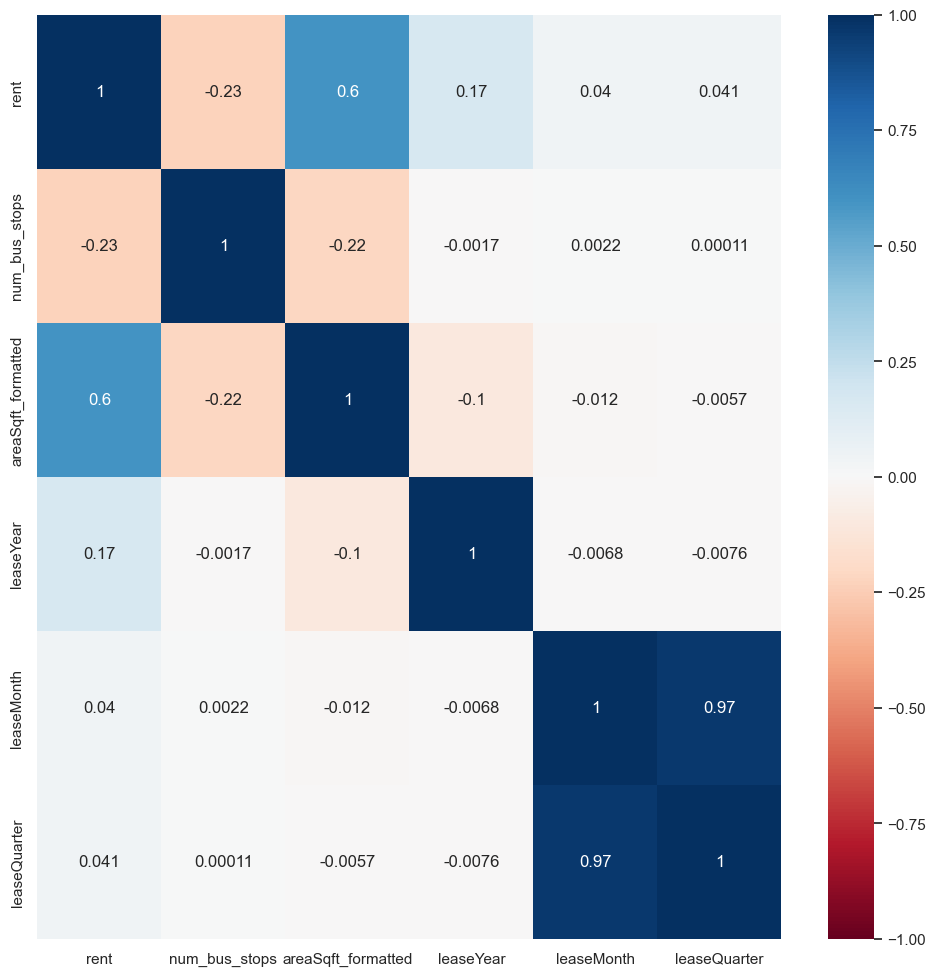

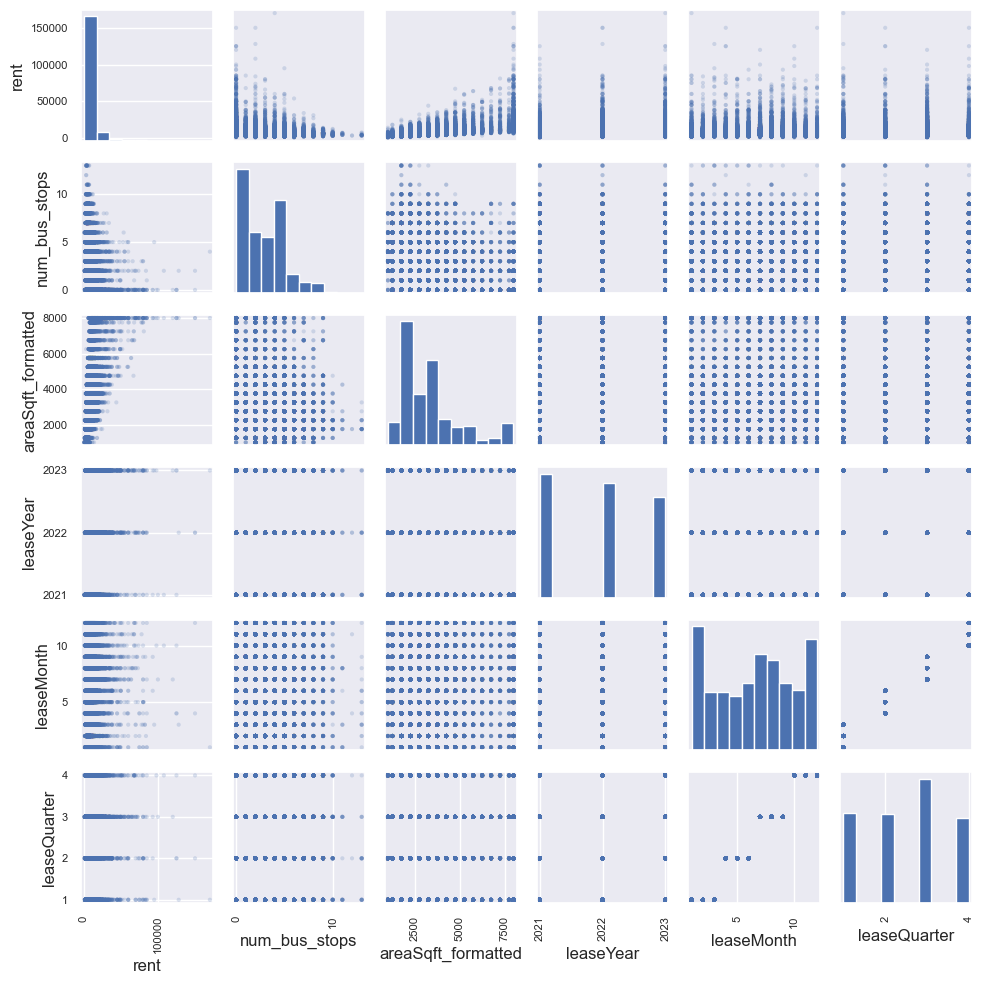

In [23]:
get_corr_plot(landed[['rent', 'num_bus_stops',
       'areaSqft_formatted',
       'leaseYear', 'leaseMonth', 'leaseQuarter']])
pairs(landed[['rent', 'num_bus_stops',
       'areaSqft_formatted',
       'leaseYear', 'leaseMonth', 'leaseQuarter']])

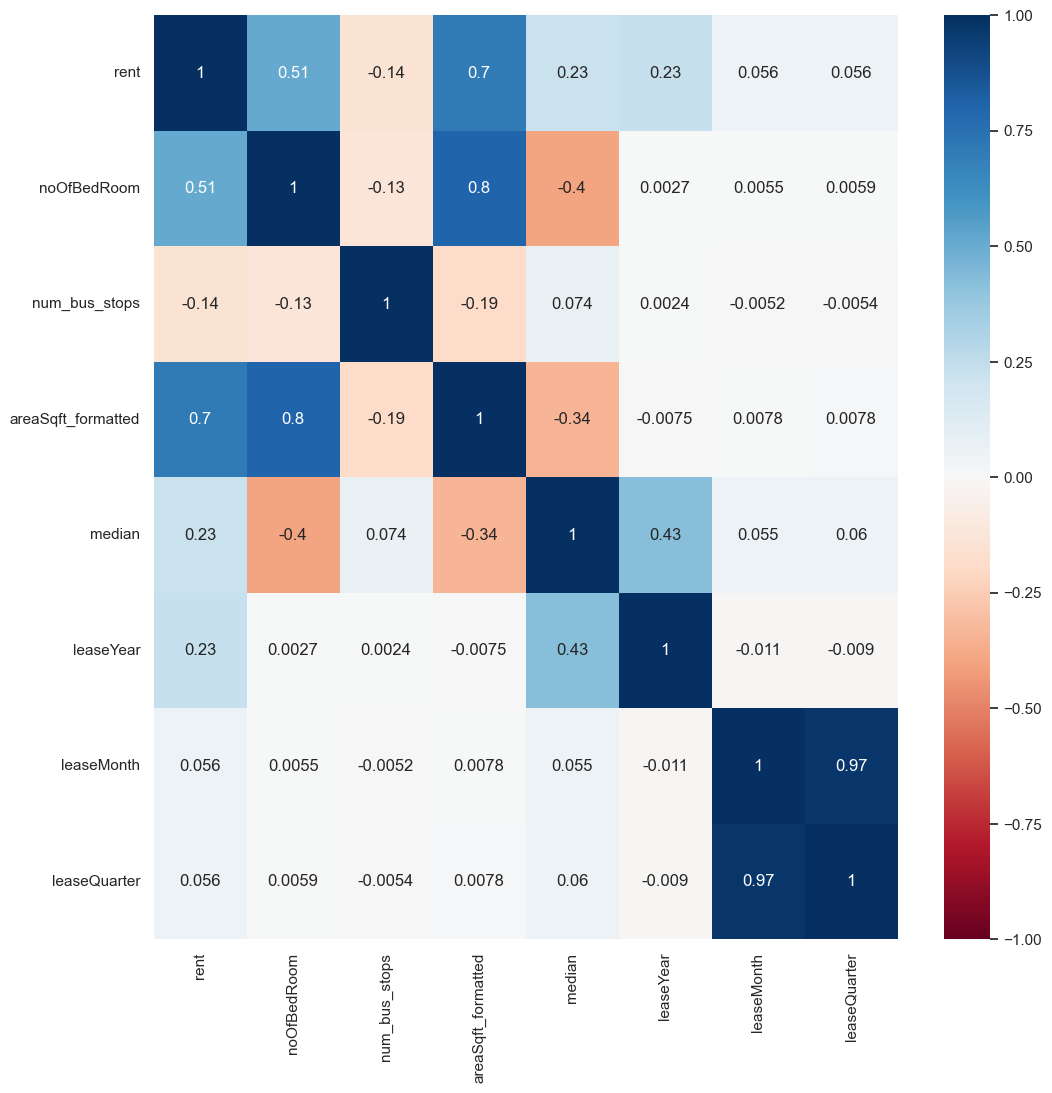

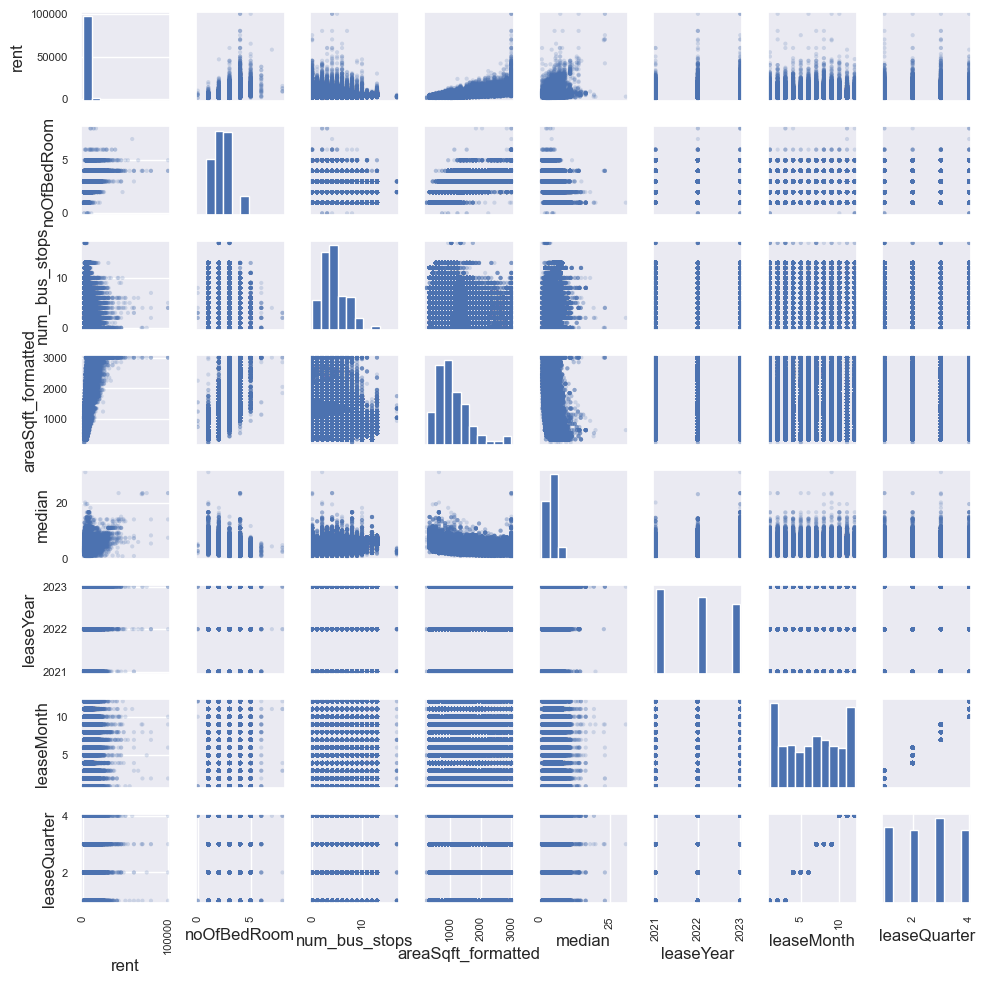

In [24]:
get_corr_plot(nonlanded[['rent', 'noOfBedRoom', 'num_bus_stops',
       'areaSqft_formatted', 'median',
       'leaseYear', 'leaseMonth', 'leaseQuarter']])
pairs(nonlanded[['rent', 'noOfBedRoom', 'num_bus_stops',
       'areaSqft_formatted', 'median',
       'leaseYear', 'leaseMonth', 'leaseQuarter']] )

# Modelling

## No transformations

### Landed

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'num_bus_stops', 'district_02', 'district_03', 'district_04', 'district_05', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     517.4
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:26:24   Log-Likelihood:            -1.6256e+05
No. Observations: 

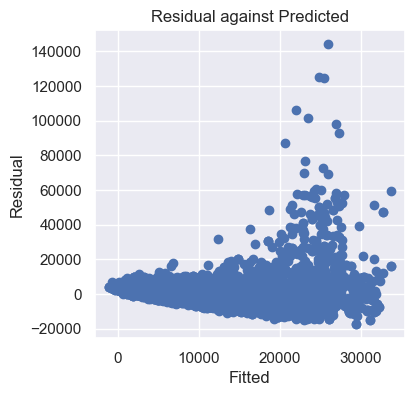

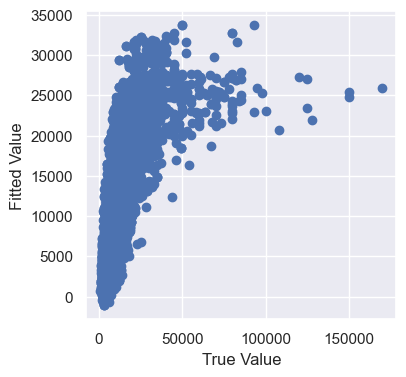

MSE using testing data = 26860614.309318513
RMSE using testing data= 5182.7226733946045
MAE using testing data = 2972.526331815804


In [25]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

### Non-landed

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'num_bus_stops', 'median', 'district_02', 'district_03', 'district_04', 'district_05', 'district_06', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']


                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 1.770e+04
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:26:26   Log-Likelihood:            -1.6433e+06
No. Observations:              189736   AIC:                         3.287e+06
Df Residuals:                  189703   BIC:                         3.287e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

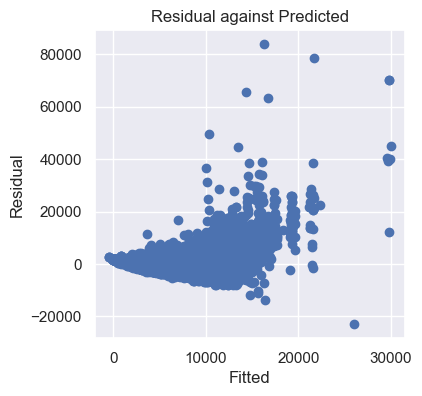

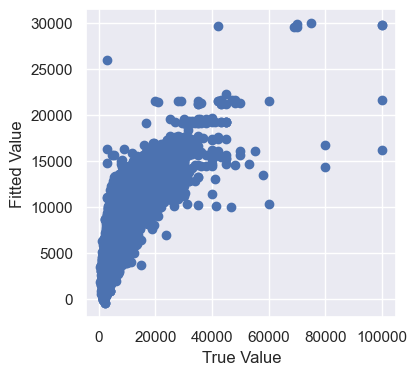

MSE using testing data = 3207098.6957785813
RMSE using testing data= 1790.8374286290148
MAE using testing data = 1267.4794982836913


In [26]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter', 'noOfBedRoom']:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], nonlanded_encoded["rent"], test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

## Ln Y

### Landed

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'num_bus_stops', 'district_02', 'district_03', 'district_04', 'district_05', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1047.
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:26:27   Log-Likelihood:                -5573.4
No. Observations: 

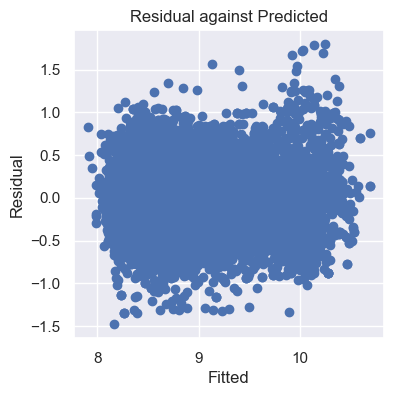

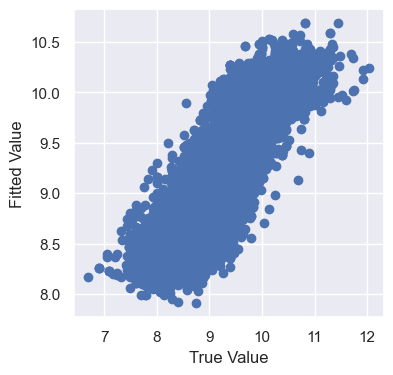

MSE using testing data = 0.10971854733127394
RMSE using testing data= 0.33123790141116694
MAE using testing data = 0.26133344106017475


In [27]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], np.log(landed_encoded["rent"]), test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

### Non-landed

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'num_bus_stops', 'median', 'district_02', 'district_03', 'district_04', 'district_05', 'district_06', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 2.817e+04
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:26:29   Log-Likelihood:              

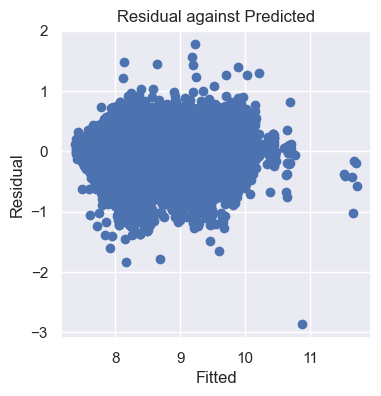

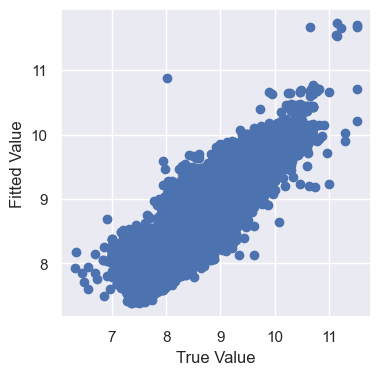

MSE using testing data = 0.05156540365416599
RMSE using testing data= 0.22708017010334916
MAE using testing data = 0.17178520676653278


In [28]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter', 'noOfBedRoom']:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], np.log(nonlanded_encoded["rent"]), test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

## Backward Selection

### Landed

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1119.
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:40:00   Log-Likelihood:                -5574.5
No. Observations:               16126   AIC:                         1.121e+04
Df Residuals:                   16096   BIC:                         1.144e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

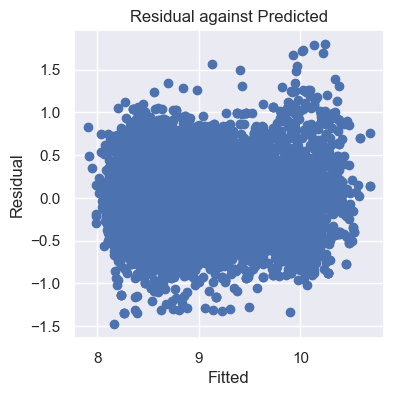

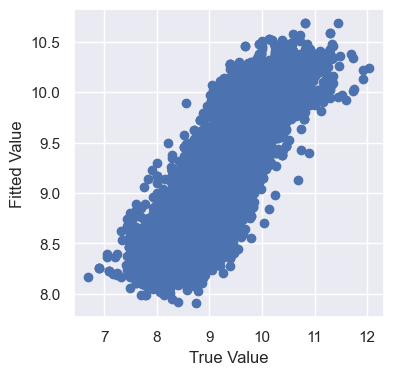

MSE using testing data = 0.10972562568393437
RMSE using testing data= 0.3312485859349959
MAE using testing data = 0.26134799155071775
MAE calculated from reverse transformed predictions: 2647.7484128568094


In [53]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], np.log(landed_encoded["rent"]), test_size=0.2, random_state=42)
backwards_selection_results = backwards_selection(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

test_result_df = backwards_selection_results["result_df"]
test_result_df["predicted_rent"] = np.exp(test_result_df["fitted"])
test_result_df["rent"] = np.exp(test_result_df["true"])
print(f"""MAE calculated from reverse transformed predictions: {mean_absolute_error(test_result_df["rent"], test_result_df["predicted_rent"])}""")

Text(0.5, 1.0, 'Magnitude of Estimated Coefficients: Top 10')

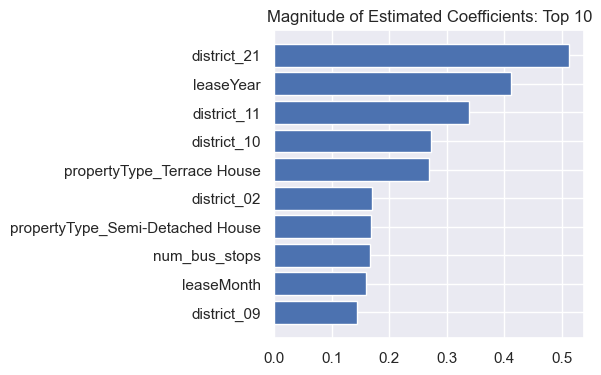

In [54]:
est_params = backwards_selection_results["model"].params
est_params = np.abs(est_params).sort_values()[:10]

plt.figure(figsize=(4, 4))
plt.barh(y = est_params.index, width=est_params)
plt.title("Magnitude of Estimated Coefficients: Top 10")

### Non-landed

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 2.908e+04
Date:                Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:37:36   Log-Likelihood:                 47713.
No. Observations:              189736   AIC:                        -9.536e+04
Df Residuals:                  189704   BIC:                        -9.504e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.3868      0

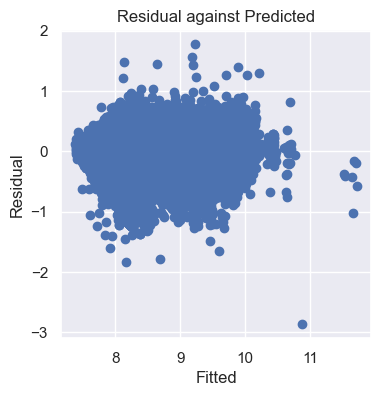

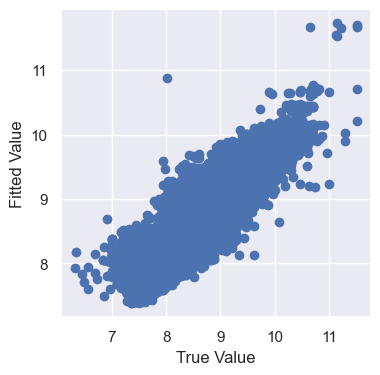

MSE using testing data = 0.05157657693727474
RMSE using testing data= 0.22710477083776717
MAE using testing data = 0.17179981451103668
MAE calculated from reverse transformed predictions: 682.0923544502015


In [49]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter', 'noOfBedRoom']:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], np.log(nonlanded_encoded["rent"]), test_size=0.2, random_state=42)
backwards_selection_results = backwards_selection(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

test_result_df = backwards_selection_results["result_df"]
test_result_df["predicted_rent"] = np.exp(test_result_df["fitted"])
test_result_df["rent"] = np.exp(test_result_df["true"])
print(f"""MAE calculated from reverse transformed predictions: {mean_absolute_error(test_result_df["rent"], test_result_df["predicted_rent"])}""")

Text(0.5, 1.0, 'Magnitude of Estimated Coefficients: Top 10')

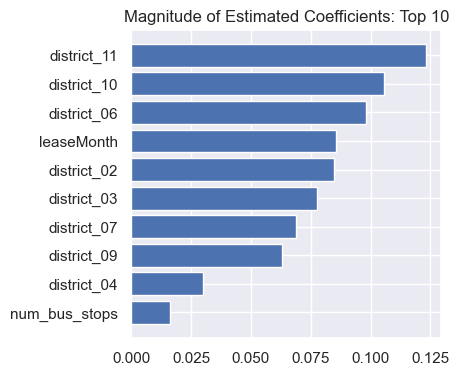

In [52]:
est_params = backwards_selection_results["model"].params
est_params = np.abs(est_params).sort_values()[:10]

plt.figure(figsize=(4, 4))
plt.barh(y = est_params.index, width=est_params)
plt.title("Magnitude of Estimated Coefficients: Top 10")